<a href="https://colab.research.google.com/github/Aveturi13/cmri_planning/blob/master/notebooks/param_est.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Automating Cardiac MRI Planning using Deep Learning: Part II**



This is the second part of cardiac MRI planning automation using Deep Learning. [Previously](https://colab.research.google.com/drive/1BBf7OlOckzJqx2R8A40NwMLU4RykVVXi?authuser=1#scrollTo=0X7_ub_e506w), I performed 2Ch line planning using a semantic segmentation approach. In this notebook, I perform parameter estimation.

**What is parameter estimation?**

Parameter estimation is essentially a regression problem, where the parameters of the line equation are predicted from the image provided. This is done by passing the image through a convolution neural network model. Through multiple convolution layers, the image is downsampled and features are learnt. At the end of the network, the feature map is flattened and passed through fully-connected layers and the final output is predicted.

**What parameters are estimated?**

Lines are known to be represented by the equation $y = mx + b$, where $m$ is the slope and $b$ is the intercept. We could simply design a neural network to predict these two parameters, however, it must be noted that the range for both these parameters is $[-\infty, +\infty]$. This means that $m$ and $b$ are not bounded values, and so predicting these values will be difficult for the neural network. Therefore, it would be better if the lines could be expressed in terms of parameters that are bounded.

The polar form of the line equation would be a better choice. Here, a segment is drawn from the origin perpendicular to the 2Ch line. The length of this segment is called $r$ and the angle between the segment and the x-axis is $\theta$. Using $r$ and $\theta$, we can express any line by the equation $$r = x\cos(\theta) + y\sin(\theta)$$

<p align="center">
<img src="https://lh3.googleusercontent.com/proxy/HhYMuvaiv9BJ3wv0wJkHUb0Y0ZGULetlXvgK3IPjoCsmSTIgPKvDg1IbzU5J_RMq6p-o7qr5Z2teqNGg3le98s_6ocFx33wcYErhg43eTag_aWQbqhmwJfyNHSinPO_0N4JcXFySf1crmI8qIeGid1OaGIZ0iziuTOod_PssGTRo">
</p>

This form is better as the length of $r$ will only lie in range $[0, d]$ where $d$ is the length of the image diagonal and $\theta$ will be between $[0, 2\pi]$ radians. So the parameters are bounded in a range which makes learning easier for a neural network. So rather than predicting $m$ and $b$, the goal is to train the neural network to predict $r$ and $\theta$ parameters for the 2Ch line, given a 4Ch image.

I begin by importing the datasets from my drive into the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Change to project directory
%cd drive/My Drive/ML Projects/cardiac_image_planning/notebooks/

## 1.0 - Importing required modules and packages

---



In [ ]:
import os, glob
from math import pi, acos, cos, sqrt, sin, atan, asin, tan
from random import shuffle, seed, setstate, getstate
import pandas as pd
import numpy as np
import cv2 as cv
from PIL import ImageFont, ImageDraw, Image
from matplotlib import pyplot as plt
from keras_preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import normalize, scale

## 2.0 - Importing and Inspecting data

The images are stored in the dataset directory. Let's load the filepaths into memory.

In [ ]:
data_path = '../dataset/two_2_four_justdiastole'
glob_search = os.path.join(data_path, '00*.png')
img_dir = sorted(glob.glob(glob_search))
print(img_dir)

/content/drive/My Drive/ML Projects/cardiac_image_planning


The 2Ch planning lines for these 4Ch images are numerically represented by a coordinate $(x, y)$ and the slope of the line $dy/dx$. These values are stored in the csv file `'two_2_four_diastole.csv'`. Let's load these values.

In [ ]:
#Read the csv file
df = pd.read_csv('datasets/fourc_pred_twoc.csv', header=None, names=['x', 'y', 'dx', 'dy'])

#Presenting data
line_data = df.iloc[:, :]
print(line_data.head())

            x           y         dx          dy
0   88.656968   91.981815  77.949571  124.721745
1  162.645745  102.514604 -66.311019   95.066142
2  111.146288  178.712147  92.911195  -82.967343
3  179.808242   97.404423 -75.815464  100.255553
4  132.123605  183.549039  77.485904  -73.764198


The rows are the values for each image. The columns correspond to `x`, `y`, `dx`, `dy` respectively. For doing operations on the data, the values are taken from the dataframe and represented as a matrix.

In [ ]:
#Convert dataframe into a matrix
line_array = line_data.values
print(line_array)

A few images are inspected below. To construct the 2Ch planning line on the image, I use the equation y = mx + b where m is the slope and b is the intercept calculated using the values in `'two_2_four_diastole.csv'`.

In [ ]:
print('Number of Patients: {} patients.\n'.format(line_array.shape[0]))

for i in range(5):
  plt.figure()
  img = plt.imread(img_dir[i])
  plt.imshow(img, plt.cm.gray)

  m = line_array[i, 3] / line_array[i, 2] 
  b = line_array[i, 1] - m * line_array[i, 0]

  x = np.arange(0, img.shape[1])
  y = m*x + b 
  plt.plot(x, y, 'red')

  plt.xlim(0, img.shape[1]-1)
  plt.ylim(img.shape[0]-1, 0)
  plt.title('Image Size: {}'.format(img.shape))
  plt.colorbar()

## 3.0 - Data Preprocessing

From the image dataset exploration, it can be seen that the images are of different sizes. Also, for performing parameter estimation, the target line parameters need to be converted into $r$ and $\theta$. This is done using a preprocessing function has been implemented below. Preprocessing will take a few minutes.

In [ ]:
from helper_functions import paramest

In [ ]:
# images is an array of shape (dataset size, 160, 160, 1) and params is a list of 2 arrays [r_values, theta_values]
images, params = paramest.load_data(img_dir, line_array)

The images and lines are visualized below.

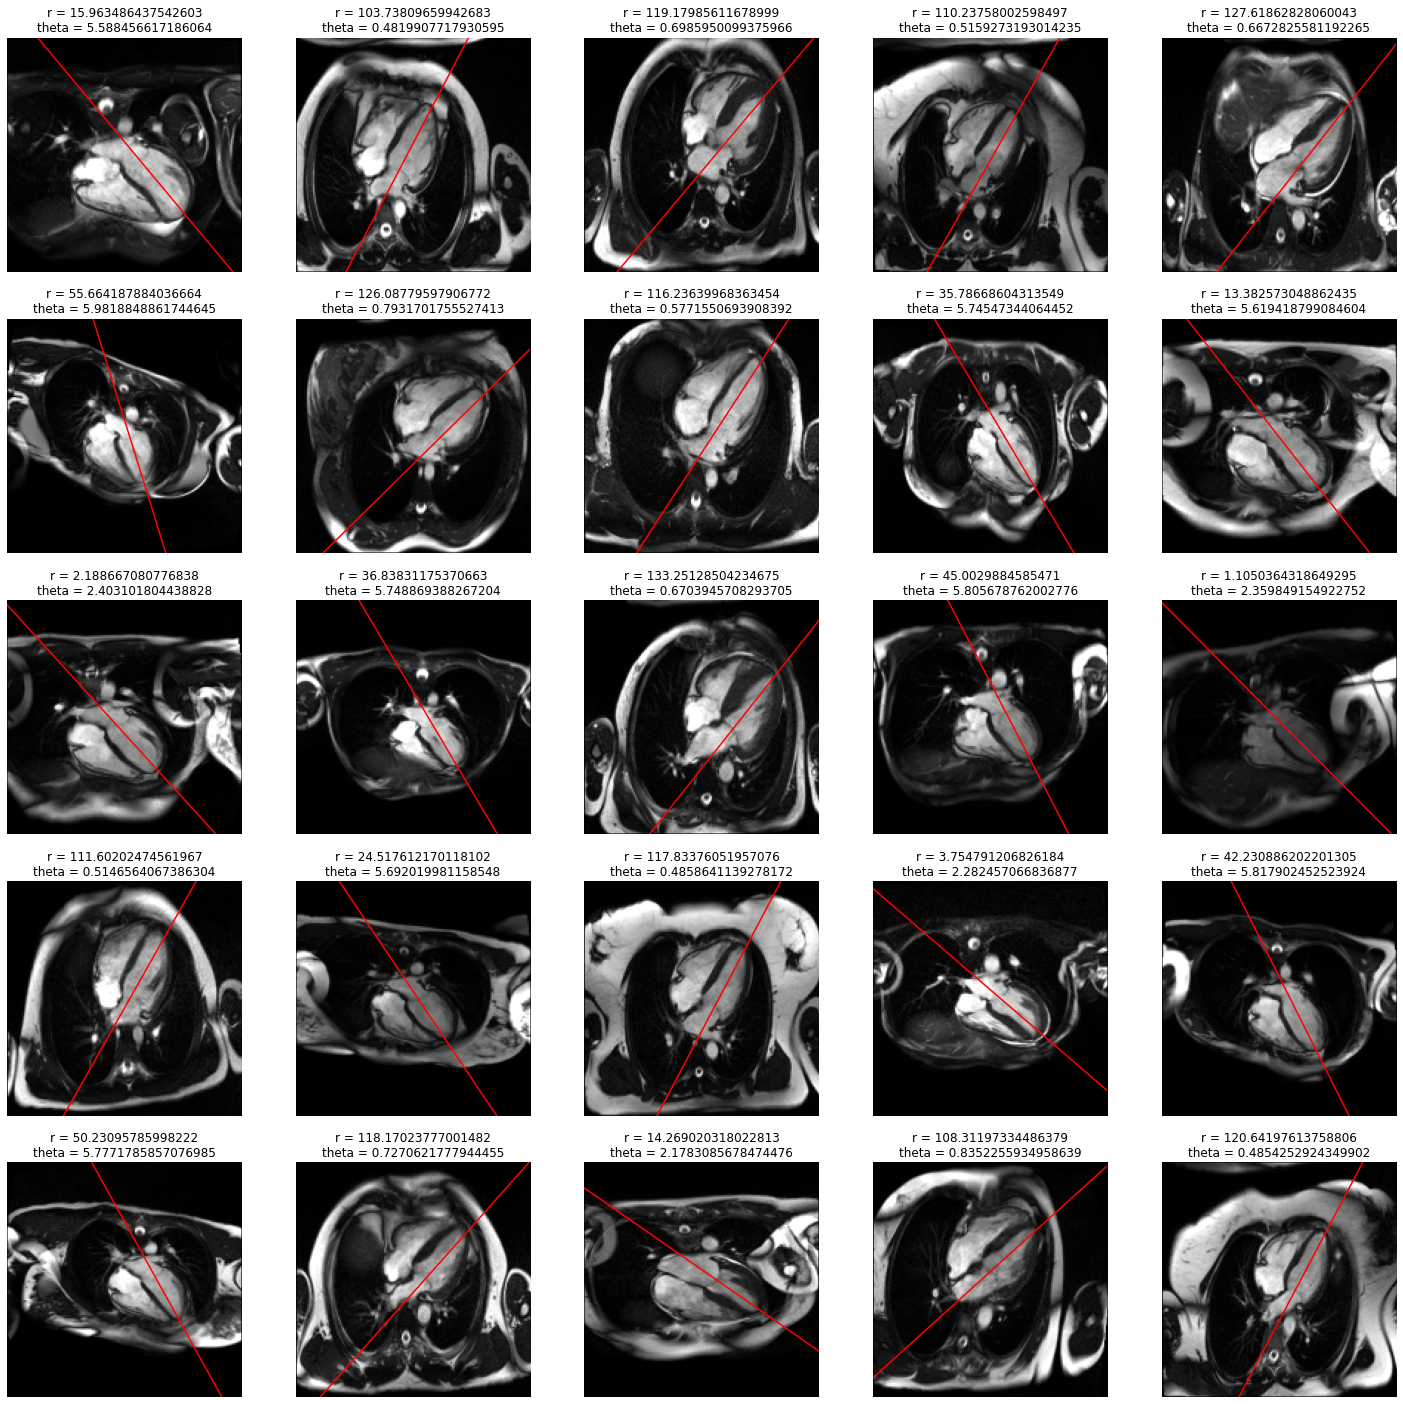

In [ ]:
r_values, theta_values = params[:, 0], params[:, 1]
N=25

#Create a grid of N examples from the dataset
plt.figure(figsize=(25,25))

for i in range(N):
  
  image = images[i].squeeze()
  r = r_values[i] * np.sqrt(160**2 + 160**2) 
  theta = theta_values[i] * (2*np.pi)

  plt.subplot(5, 5, i+1)
  plt.axis('off')

  #Display image
  plt.imshow(image, plt.cm.gray)

  #Compute line
  x = np.arange(0, 160)
  y = (r - x*np.cos(theta))/np.sin(theta)

  #Display line on the image in red
  plt.plot(x, y, 'red')

  plt.xlim(0, 159)
  plt.ylim(159, 0)

  plt.title('r' + str(r) + '\ntheta = ' + str(theta))

## 4.0 - Data Generator

Depending of whether we want to optimize just $r$, just $\theta$ or both together, set the value of `optimize` below to `'r'`, `'theta'` or `'both'`. This functionality was included because during the project, instead of predicting both parameters at the same time, I wanted to first test if the neural networks was able to learn just one of the parameters.

In [ ]:
optimize = 'both'

if optimize == 'r':
  param_of_interest = params[:, 0]
elif optimize == 'theta':
  param_of_interest = params[:, 1]
elif optimize == 'both':
  param_of_interest = params

In [ ]:
idg = ImageDataGenerator()

The images and targets are passed to the deep learning model using a generator function. First, the data must be divided into training and validation sets.

In [ ]:
batch_size = 128
np.random.seed(1)

#Shuffle data
state = np.random.get_state()
images_shuffled = np.random.permutation(images)
np.random.set_state(state)
params_shuffled = np.random.permutation(param_of_interest)

#Setup train and val sets
split_index = int(0.80 * images_shuffled.shape[0])

train_images = images_shuffled[:split_index] 
train_params = params_shuffled[:split_index]

val_images = images_shuffled[split_index:]
val_params = params_shuffled[split_index:]

In [ ]:
#Create training and validation set generators
train_generator = idg.flow(train_images, train_params, batch_size=batch_size, shuffle=True) 
validation_data = (val_images, val_params)

In [ ]:
np.random.seed(1)
X, Y = next(train_generator)

Don't run the below cell unless `optimize == 'both'`:

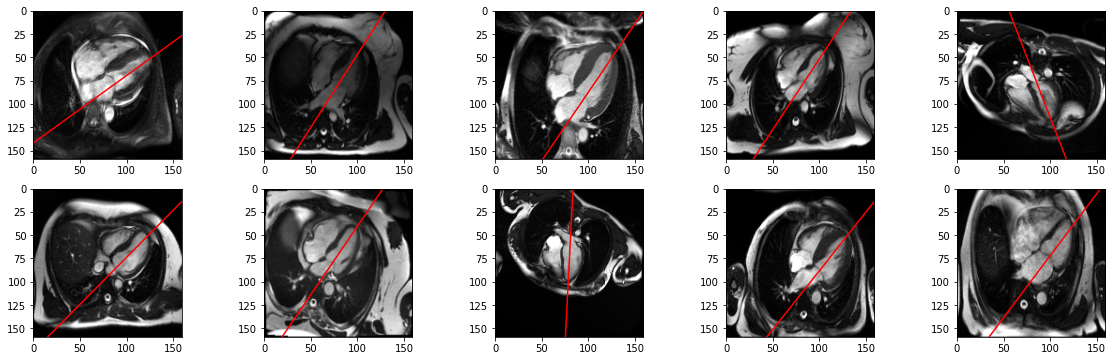

In [ ]:
plt.figure(figsize=(20, 6))

r_batch = Y[:, 0]
theta_batch = Y[:, 1]

for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(X[i].squeeze(), cmap=plt.cm.gray)

  r = r_batch[i] * np.sqrt(160**2 + 160**2)
  theta = theta_batch[i] * (2* np.pi)

  x = np.arange(0, 160)
  y = (r - x*np.cos(theta))/np.sin(theta)
  plt.plot(x, y, 'red')

  plt.xlim(0, 159)
  plt.ylim(159, 0)

## 5.0 - Preparing Deep Learning Model

The deep learning model that will be used to predict the planning line is the AlexNet architecture. The original paper describing this architecture is described in this [paper](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf). For this project, I have slightly modified the architecture to deal with my images, which is shown below.

The AlexNet model is imported below.

In [ ]:
from networks import alexnet
import keras
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K

The mean squared error is chosen as the loss function to optimize the neural network.

In [ ]:
model = alexnet(batchnorm=True, dropout=0.0, optimize='both')
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



The model is summarized below.

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 160, 160, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 38, 38, 96)        11712     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 18, 18, 96)        384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 256)       614656    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 256)         1024

### 5.1 Build Callbacks

Callbacks are important for monitoring the progress of the model training over each epoch.

In [ ]:
def build_callbacks():
  #Instance of ModelCheckpoint class = ModelCheckpoint class saves the model after every epoch.
  checkpointer = ModelCheckpoint(filepath='model_2/V.16/model.h5', verbose=0, save_best_only=True, save_weights_only=True)
  callbacks = [checkpointer]
  return callbacks

## 6.0 - Model Training

The below code is to train the model. The model is trained for 30 epochs.

In [ ]:
train_steps=len(train_images)//128
model.fit(x=train_generator,
          epochs=30,
          verbose=1,
          callbacks=build_callbacks(),
          validation_data=validation_data,
          steps_per_epoch=train_steps)


Epoch 1/30
100/100 [==============================] - 14s 144ms/step - loss: 0.0428 - val_loss: 0.1499
i= 1 loss= 0.042648030421475774 val_loss= 0.14990292489528656
Epoch 2/30
100/100 [==============================] - 6s 59ms/step - loss: 0.0299 - val_loss: 0.2515
i= 2 loss= 0.029903338344594868 val_loss= 0.25150030851364136
Epoch 3/30
100/100 [==============================] - 6s 61ms/step - loss: 0.0258 - val_loss: 0.2447
i= 3 loss= 0.025809405348810953 val_loss= 0.24470581615068873
Epoch 4/30
100/100 [==============================] - 6s 59ms/step - loss: 0.0230 - val_loss: 0.1882
i= 4 loss= 0.023087233449687664 val_loss= 0.18815036118030548
Epoch 5/30
100/100 [==============================] - 6s 58ms/step - loss: 0.0212 - val_loss: 0.1172
i= 5 loss= 0.021126879691463155 val_loss= 0.11724767998838034
Epoch 6/30
100/100 [==============================] - 6s 59ms/step - loss: 0.0188 - val_loss: 0.0647
i= 6 loss= 0.018809533584517302 val_loss= 0.06467168961392074
Epoch 7/30
100/100 

## 7.0 - Model Evaluation

Now the model is evaluated for it's prediction on unseen images. As the dataset is quite small, the validation set images were used as the test images.

### 7.1 - Load Previous Model

In [ ]:
#Destination to save and load data
dest_path = 'parameter_estimation/final_model/'

#Loading pre-existing weights
model.load_weights(dest_path + 'weights_model.h5')

### 7.2 - Visualize Metrics

The loss and accuracy metrics over each epoch of training are visualized in the below code.

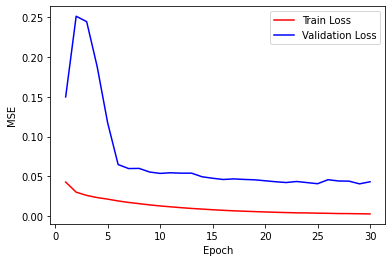

In [ ]:
#Plot evaluation metrics
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs = np.arange(1, 31)

#plt.subplot(1, 2, 1)
plt.plot(epochs, loss, color='red')
plt.plot(epochs, val_loss, color='blue')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(['Train Loss', 'Validation Loss'])

#Save file to metrics folder
#plt.savefig(dest_path + 'metrics')

plt.show()

### 7.3 - Viewing Test images

The model was used to predict the $r$ and $\theta$ parameters for the test images. Using these parameters, the lines were constructed for the test images. The true lines are also visualized on the images for comparison.

To numerically evaluate the line as well, the RMSD metric, which I described in the previous notebook, was used. 

In [ ]:
def RMSD(A, B, C, points):
  x0, y0 = points
  distance = np.abs(A*x0 + B*y0 + C) /np.sqrt(A**2 + B**2)
  return np.sqrt(np.mean(distance**2))

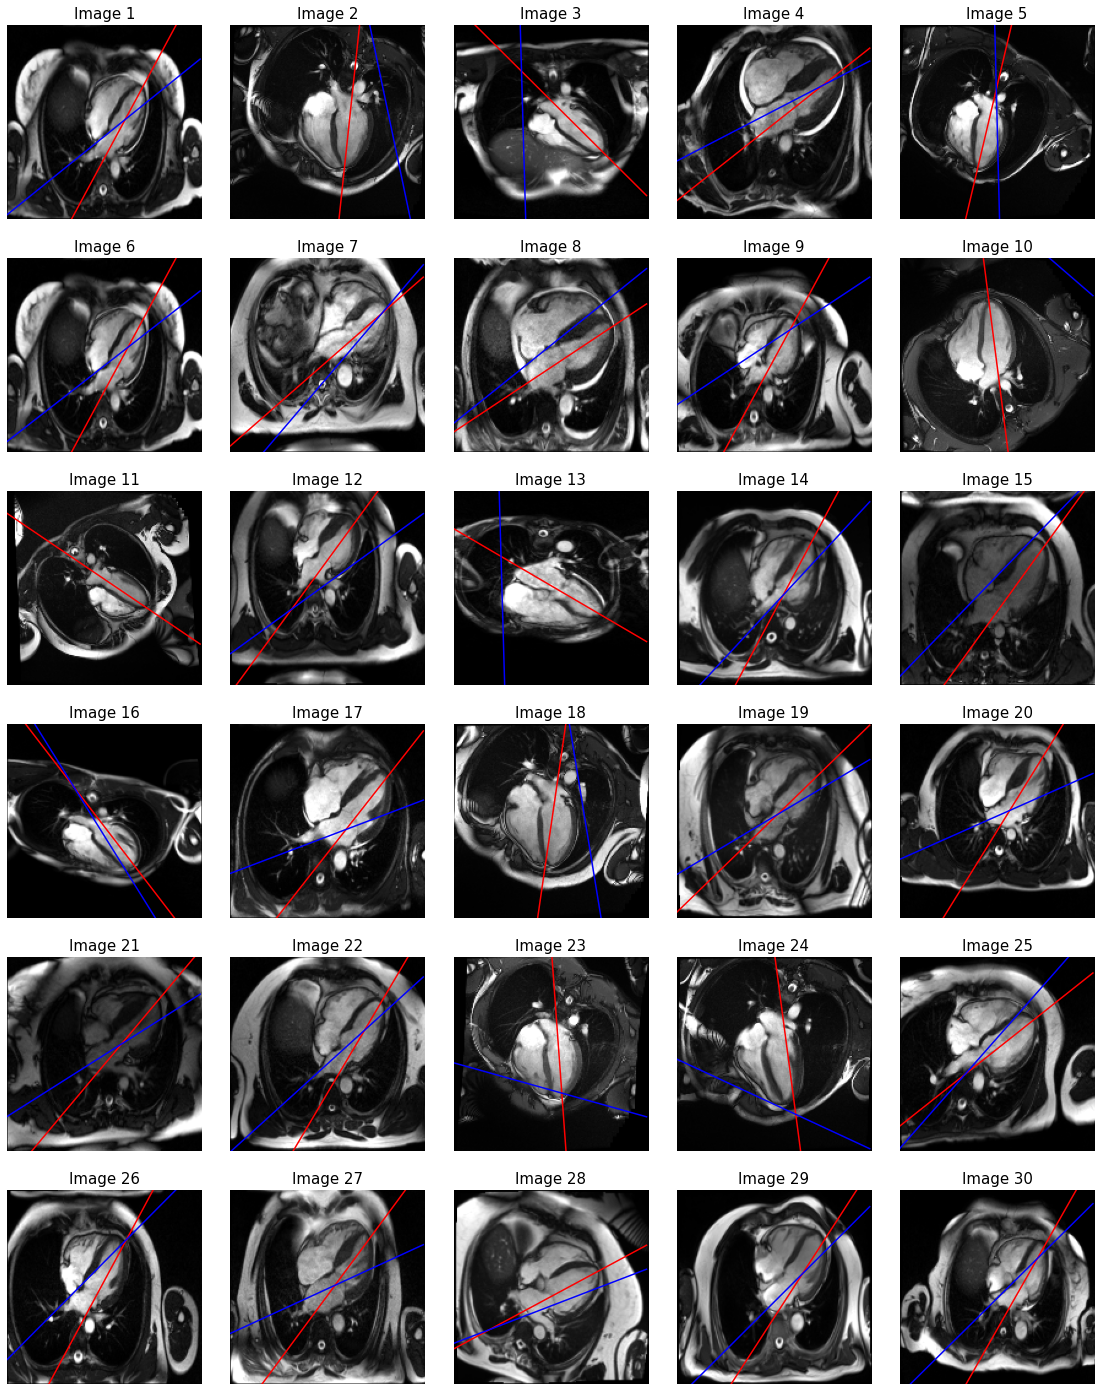

In [ ]:
test_images = val_images # 160,160,1 images
test_params = val_params

optimized = 'both'

#True values
r_true = test_params[:, 0] * np.sqrt(160**2 + 160**2)
theta_true = test_params[:, 1] * 2 * np.pi

#Generate predictions
predictions = model.predict_on_batch(test_images).squeeze()

if optimized == 'r':
  r_pred = predictions * np.sqrt(160**2 + 160**2)
  theta_pred = theta_true

elif optimized == 'theta':
  r_pred = test_r_true
  theta_pred = predictions * 2 * np.pi

elif optimized == 'both':
  r_pred = predictions[:, 0] * np.sqrt(160**2 + 160**2)
  theta_pred = predictions[:, 1] * 2 * np.pi

test_images = test_images.squeeze()

#Computing mean distance between true and predicted line
distances = []

#PLOT RESULTS
plot_results = True
N = 30 #Number of images to plot
fig = plt.figure(figsize=(20, 25))
for k in range(N):

  image = test_images[k]

  #Convert the parameters into m_pred/m_true and b_pred/b_true
  m_pred = -1 * np.cos(theta_pred[k])/np.sin(theta_pred[k])
  m_true = -1 * np.cos(theta_true[k])/np.sin(theta_true[k])
  b_pred = r_pred[k]/np.sin(theta_pred[k])
  b_true = r_true[k]/np.sin(theta_true[k])

  #---COMPUTE MEAN DISTANCE---#
  boundary_points = []
  p1 = (-b_true/m_true, 0)
  p2 = (0, b_true)
  p3 = (159, 159*m_true + b_true)
  p4 = ((159-b_true)/m_true, 159)

  for (i, j) in [p1, p2, p3, p4]:
    if 0 <= i <= 159 and 0 <= j <= 159:
      boundary_points.append((i, j))

  bp1, bp2 = boundary_points

  x = np.linspace(bp1[0], bp2[0], 200)
  y_true = m_true*x + b_true

  # For each of these 200 points, find the nearest point in line 2.
  A, B, C = m_pred, -1, b_pred
  mean_distance = RMSD(A, B, C, (x, y_true))
  distances.append(mean_distance)

  y_pred = m_pred*x + b_pred

  #Plot results
  if plot_results:
    plt.subplot(N/5, 5, k+1)
    plt.axis('off')
    plt.imshow(image, plt.cm.gray)
    x = np.arange(0, 159)
    y_true = m_true*x + b_true
    y_pred = m_pred*x + b_pred
    plt.plot(x, y_true, 'red')
    plt.plot(x, y_pred, 'blue')
    plt.xlim(0, 159)
    plt.ylim(159, 0)
    plt.legend(['True', 'Predicted'])

    plt.title('RMSD = {}'.format(mean_distance), {'fontsize': 15})
    fig.subplots_adjust(wspace=0, hspace=0.2)

    #plt.savefig(dest_path + 'final_results/predictions' + str(k))

## 8.0 - Save Results

The model weights and training history are saved using the code below.

In [ ]:
#Destination to save and load data
dest_path = 'parameter_estimation/final_model/'

#Saving weights to file
model.save_weights(dest_path + 'weights_model.h5')

#Saving the training history:
import pickle
with open(dest_path + 'trainHistoryDict', 'wb') as file_pi:
  pickle.dump(model.history.history, file_pi)

The code below saves the true and predicted results to an excel spreadsheet.

In [ ]:
results = pd.DataFrame({'r_true':test_r_true,
                        'r_pred':test_r_pred,
                        'theta_true':test_theta_true, 'theta_pred':test_theta_pred, 'theta_error':theta_error})

print(results.head(10))

print('\nMean Absolute Error on r = ' + str(np.mean(np.abs(r_error))))
print('Standard Deviation= ' + str(np.std(r_error)))
print('Mean theta error= ' + str(np.mean(np.abs(theta_error))))
print('Standard Deviation= ' + str(np.std(theta_error)))

results.to_excel(dest_path + 'results.xlsx')

       r_true      r_pred    r_error  theta_true  theta_pred  theta_error
0  121.864868  121.027863   0.837005    0.494190    0.892296    -0.398106
1  105.222508  111.624542  -6.402034    0.105640    6.076513    -5.970873
2   12.267931   54.537018 -42.269087    5.495054    6.255119    -0.760066
3  112.974984   99.052864  13.922120    0.901881    1.092803    -0.190921
4   88.932050   77.561348  11.370702    0.232360    6.258457    -6.026097
5  121.864868  118.619629   3.245239    0.494190    0.908544    -0.414354
6  115.950392  123.926811  -7.976419    0.852255    0.706115     0.146140
7  118.895591  105.764320  13.131271    0.984607    0.895067     0.089540
8  109.627731  100.404373   9.223358    0.496734    0.986127    -0.489393
9   67.706765   79.902344 -12.195578    6.156344    5.425635     0.730709

Mean Absolute Error on r = 11.789459227524953
Standard Deviation= 16.469268606219345
Mean theta error= 0.9377829651621478
Standard Deviation= 1.705110890975637
